<a href="https://colab.research.google.com/github/foadolfat/131_Lab_02_GUI/blob/main/CSC180FinalProjectPhucTruongFoadOlfat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Library imports**

In [ ]:
#imports and function definition

from collections.abc import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from pandas.api.types import is_numeric_dtype
from collections.abc import Sequence
from sklearn.model_selection import train_test_split
from sklearn import metrics 
import sklearn.feature_extraction.text as sk_text
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import time
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


import json 
import csv 

### **Importing data**

In [ ]:


df = pd.read_csv('data.csv', sep=';')

print(df.head(1))


   Marital status  Application mode  Application order  Course  \
0               1                17                  5     171   

   Daytime/evening attendance\t  Previous qualification  \
0                             1                       1   

   Previous qualification (grade)  Nacionality  Mother's qualification  \
0                           122.0            1                      19   

   Father's qualification  ...  Curricular units 2nd sem (credited)  \
0                      12  ...                                    0   

   Curricular units 2nd sem (enrolled)  \
0                                    0   

   Curricular units 2nd sem (evaluations)  \
0                                       0   

   Curricular units 2nd sem (approved)  Curricular units 2nd sem (grade)  \
0                                    0                               0.0   

   Curricular units 2nd sem (without evaluations)  Unemployment rate  \
0                                               0      

### **Defining useful functions**

In [ ]:
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()




# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

def labelEncodeOutcome(x):
    if(type(x) is str):
        if(x == "Dropout"):
            return 0
        
        else:
            return 1
    else: 
        return 

## **Data cleaning**

In [ ]:
#replace missing values with median
for column in df:
    if(is_numeric_dtype(df[column])):
        missing_median(df, column)

#remove redundencies
df_no_dup = df.drop_duplicates()

#zscore normalize all numeric columns
for column in df_no_dup:
    if(is_numeric_dtype(df_no_dup[column])):
        encode_numeric_zscore(df_no_dup, column)
df_no_dup


,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,-0.294795,-0.095459,2.490614,-4.209044,0.350043,-0.350191,-0.804750,-0.126284,-0.036014,-0.669702,...,-0.28241,-2.838016,-2.042399,-1.471361,-1.963267,-0.199418,-0.287606,0.124372,0.765674,Dropout
1,-0.294795,-0.209845,-0.554005,0.192559,0.350043,-0.350191,2.076585,-0.126284,-1.189625,-1.256285,...,-0.28241,-0.105714,-0.522623,0.518845,0.659487,-0.199418,0.876123,-1.105097,0.347160,Graduate
2,-0.294795,-1.010546,2.490614,0.103393,0.350043,-0.350191,-0.804750,-0.126284,1.117596,0.959694,...,-0.28241,-0.105714,-2.042399,-1.471361,-1.963267,-0.199418,-0.287606,0.124372,0.765674,Dropout
3,-0.294795,-0.095459,0.207150,0.444065,0.350043,-0.350191,-0.804750,-0.126284,1.181686,0.959694,...,-0.28241,-0.105714,0.490561,0.187144,0.416403,-0.199418,-0.813161,-1.466705,-1.375356,Graduate
4,1.356059,1.162785,-0.554005,-0.408343,-2.856147,-0.350191,-2.472892,-0.126284,1.117596,1.024870,...,-0.28241,-0.105714,-0.522623,0.518845,0.531548,-0.199418,0.876123,-1.105097,0.347160,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,-0.294795,-1.010546,3.251769,0.444065,0.350043,-0.350191,-0.577276,-0.126284,-1.189625,-1.386637,...,-0.28241,-0.105714,-0.016031,0.187144,0.467578,-0.199418,1.476757,1.136876,-1.789464,Graduate
4420,-0.294795,-1.010546,0.207150,0.444065,0.350043,-0.350191,-0.956399,14.914542,-1.189625,-1.386637,...,-0.28241,-0.105714,-0.522623,-0.807959,0.147730,-0.199418,-0.174987,-0.454201,0.889026,Dropout
4421,-0.294795,-1.010546,-0.554005,0.311770,0.350043,-0.350191,1.621637,-0.126284,1.117596,0.959694,...,-0.28241,0.805053,0.237265,-1.139660,0.627502,-0.199418,0.876123,-1.105097,0.347160,Dropout
4422,-0.294795,-1.010546,-0.554005,0.140707,0.350043,-0.350191,3.593077,-0.126284,1.117596,0.959694,...,-0.28241,-0.561098,-0.522623,0.187144,0.339639,-0.199418,-0.813161,-1.466705,-1.375356,Graduate


In [ ]:
#label encode outcome column
df_no_dup_encoded = df_no_dup
df_no_dup_encoded["Target"] = df_no_dup["Target"].map(labelEncodeOutcome)
df_no_dup_encoded

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,-0.294795,-0.095459,2.490614,-4.209044,0.350043,-0.350191,-0.804750,-0.126284,-0.036014,-0.669702,...,-0.28241,-2.838016,-2.042399,-1.471361,-1.963267,-0.199418,-0.287606,0.124372,0.765674,0
1,-0.294795,-0.209845,-0.554005,0.192559,0.350043,-0.350191,2.076585,-0.126284,-1.189625,-1.256285,...,-0.28241,-0.105714,-0.522623,0.518845,0.659487,-0.199418,0.876123,-1.105097,0.347160,1
2,-0.294795,-1.010546,2.490614,0.103393,0.350043,-0.350191,-0.804750,-0.126284,1.117596,0.959694,...,-0.28241,-0.105714,-2.042399,-1.471361,-1.963267,-0.199418,-0.287606,0.124372,0.765674,0
3,-0.294795,-0.095459,0.207150,0.444065,0.350043,-0.350191,-0.804750,-0.126284,1.181686,0.959694,...,-0.28241,-0.105714,0.490561,0.187144,0.416403,-0.199418,-0.813161,-1.466705,-1.375356,1
4,1.356059,1.162785,-0.554005,-0.408343,-2.856147,-0.350191,-2.472892,-0.126284,1.117596,1.024870,...,-0.28241,-0.105714,-0.522623,0.518845,0.531548,-0.199418,0.876123,-1.105097,0.347160,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,-0.294795,-1.010546,3.251769,0.444065,0.350043,-0.350191,-0.577276,-0.126284,-1.189625,-1.386637,...,-0.28241,-0.105714,-0.016031,0.187144,0.467578,-0.199418,1.476757,1.136876,-1.789464,1
4420,-0.294795,-1.010546,0.207150,0.444065,0.350043,-0.350191,-0.956399,14.914542,-1.189625,-1.386637,...,-0.28241,-0.105714,-0.522623,-0.807959,0.147730,-0.199418,-0.174987,-0.454201,0.889026,0
4421,-0.294795,-1.010546,-0.554005,0.311770,0.350043,-0.350191,1.621637,-0.126284,1.117596,0.959694,...,-0.28241,0.805053,0.237265,-1.139660,0.627502,-0.199418,0.876123,-1.105097,0.347160,0
4422,-0.294795,-1.010546,-0.554005,0.140707,0.350043,-0.350191,3.593077,-0.126284,1.117596,0.959694,...,-0.28241,-0.561098,-0.522623,0.187144,0.339639,-0.199418,-0.813161,-1.466705,-1.375356,1


In [ ]:
x,y = to_xy(df_no_dup_encoded,'Target')
print(x, y)
x_train, x_test, y_train, y_test = train_test_split (x, y, test_size=0.25, random_state=45)

[[-0.29479542 -0.09545942  2.4906144  ... -0.28760594  0.12437242
   0.7656743 ]
 [-0.29479542 -0.20984526 -0.55400515 ...  0.876123   -1.1050966
   0.3471602 ]
 [-0.29479542 -1.0105461   2.4906144  ... -0.28760594  0.12437242
   0.7656743 ]
 ...
 [-0.29479542 -1.0105461  -0.55400515 ...  0.876123   -1.1050966
   0.3471602 ]
 [-0.29479542 -1.0105461  -0.55400515 ... -0.81316096 -1.4667052
  -1.3753557 ]
 [-0.29479542 -0.49580985 -0.55400515 ...  0.4256473   1.7877717
  -0.74978733]] [[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]


# **Model training**

### **FNN**

Epoch 1/1000
104/104 - 1s - loss: 0.3928 - val_loss: 0.3275 - 701ms/epoch - 7ms/step
Epoch 2/1000
104/104 - 0s - loss: 0.3221 - val_loss: 0.3166 - 235ms/epoch - 2ms/step
Epoch 3/1000
104/104 - 0s - loss: 0.3005 - val_loss: 0.3221 - 207ms/epoch - 2ms/step
Epoch 4/1000
104/104 - 0s - loss: 0.2894 - val_loss: 0.3204 - 226ms/epoch - 2ms/step
Epoch 4: early stopping
[1 0 0 ... 1 1 1]
------------------Result for neuron count  100  activation function:  relu  optimizer:  adam
Accuracy score: 0.8679927667269439
Precision score: 0.8680990497464809
Recall score: 0.8679927667269439
F1 score: 0.8644074264502103
              precision    recall  f1-score   support

           0       0.87      0.72      0.78       372
           1       0.87      0.95      0.90       734

    accuracy                           0.87      1106
   macro avg       0.87      0.83      0.84      1106
weighted avg       0.87      0.87      0.86      1106

[[266 106]
 [ 40 694]]
Plotting confusion matrix


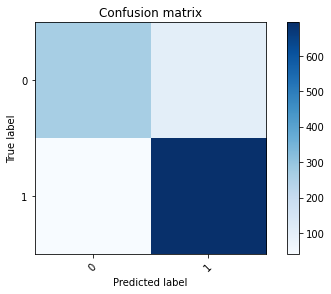

              precision    recall  f1-score   support

           0       0.87      0.72      0.78       372
           1       0.87      0.95      0.90       734

    accuracy                           0.87      1106
   macro avg       0.87      0.83      0.84      1106
weighted avg       0.87      0.87      0.86      1106

Epoch 1/1000
104/104 - 1s - loss: 0.5274 - val_loss: 0.4299 - 590ms/epoch - 6ms/step
Epoch 2/1000
104/104 - 0s - loss: 0.4059 - val_loss: 0.3733 - 185ms/epoch - 2ms/step
Epoch 3/1000
104/104 - 0s - loss: 0.3650 - val_loss: 0.3446 - 213ms/epoch - 2ms/step
Epoch 4/1000
104/104 - 0s - loss: 0.3456 - val_loss: 0.3362 - 180ms/epoch - 2ms/step
Epoch 5/1000
104/104 - 0s - loss: 0.3341 - val_loss: 0.3288 - 200ms/epoch - 2ms/step
Epoch 6/1000
104/104 - 0s - loss: 0.3261 - val_loss: 0.3265 - 180ms/epoch - 2ms/step
Epoch 7/1000
104/104 - 0s - loss: 0.3199 - val_loss: 0.3242 - 225ms/epoch - 2ms/step
Epoch 8/1000
104/104 - 0s - loss: 0.3154 - val_loss: 0.3189 - 178ms/epoch - 2m

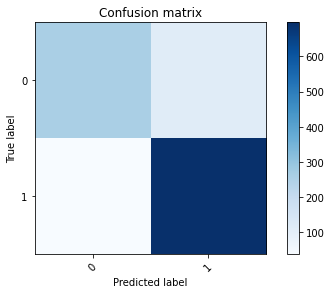

              precision    recall  f1-score   support

           0       0.88      0.70      0.78       372
           1       0.86      0.95      0.90       734

    accuracy                           0.86      1106
   macro avg       0.87      0.82      0.84      1106
weighted avg       0.87      0.86      0.86      1106

Epoch 1/1000
104/104 - 1s - loss: 0.4903 - val_loss: 0.3765 - 711ms/epoch - 7ms/step
Epoch 2/1000
104/104 - 0s - loss: 0.3632 - val_loss: 0.3204 - 209ms/epoch - 2ms/step
Epoch 3/1000
104/104 - 0s - loss: 0.3362 - val_loss: 0.3157 - 209ms/epoch - 2ms/step
Epoch 4/1000
104/104 - 0s - loss: 0.3310 - val_loss: 0.3368 - 243ms/epoch - 2ms/step
Epoch 5/1000
104/104 - 0s - loss: 0.3258 - val_loss: 0.3197 - 253ms/epoch - 2ms/step
Epoch 5: early stopping
[1 0 0 ... 1 1 1]
------------------Result for neuron count  100  activation function:  sigmoid  optimizer:  adam
Accuracy score: 0.8661844484629295
Precision score: 0.8707661529047237
Recall score: 0.8661844484629295
F1 sco

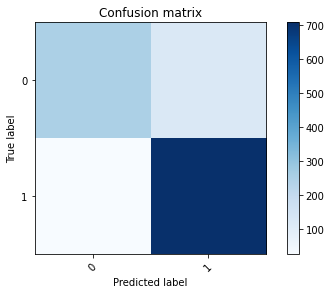

              precision    recall  f1-score   support

           0       0.91      0.67      0.77       372
           1       0.85      0.96      0.91       734

    accuracy                           0.87      1106
   macro avg       0.88      0.82      0.84      1106
weighted avg       0.87      0.87      0.86      1106

Epoch 1/1000
104/104 - 1s - loss: 0.6155 - val_loss: 0.6231 - 615ms/epoch - 6ms/step
Epoch 2/1000
104/104 - 0s - loss: 0.6026 - val_loss: 0.6102 - 203ms/epoch - 2ms/step
Epoch 3/1000
104/104 - 0s - loss: 0.5923 - val_loss: 0.5981 - 184ms/epoch - 2ms/step
Epoch 4/1000
104/104 - 0s - loss: 0.5804 - val_loss: 0.5851 - 220ms/epoch - 2ms/step
Epoch 5/1000
104/104 - 0s - loss: 0.5684 - val_loss: 0.5814 - 207ms/epoch - 2ms/step
Epoch 6/1000
104/104 - 0s - loss: 0.5564 - val_loss: 0.5596 - 178ms/epoch - 2ms/step
Epoch 7/1000
104/104 - 0s - loss: 0.5433 - val_loss: 0.5499 - 181ms/epoch - 2ms/step
Epoch 8/1000
104/104 - 0s - loss: 0.5301 - val_loss: 0.5288 - 180ms/epoch - 2m

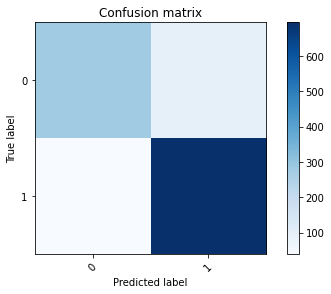

              precision    recall  f1-score   support

           0       0.88      0.75      0.81       372
           1       0.88      0.95      0.91       734

    accuracy                           0.88      1106
   macro avg       0.88      0.85      0.86      1106
weighted avg       0.88      0.88      0.88      1106

Epoch 1/1000
104/104 - 1s - loss: 0.3778 - val_loss: 0.3305 - 732ms/epoch - 7ms/step
Epoch 2/1000
104/104 - 0s - loss: 0.3306 - val_loss: 0.3201 - 228ms/epoch - 2ms/step
Epoch 3/1000
104/104 - 0s - loss: 0.3219 - val_loss: 0.3163 - 246ms/epoch - 2ms/step
Epoch 4/1000
104/104 - 0s - loss: 0.3149 - val_loss: 0.3292 - 225ms/epoch - 2ms/step
Epoch 5/1000
104/104 - 0s - loss: 0.3063 - val_loss: 0.3160 - 234ms/epoch - 2ms/step
Epoch 5: early stopping
[1 0 0 ... 1 1 1]
------------------Result for neuron count  100  activation function:  tanh  optimizer:  adam
Accuracy score: 0.8770343580470162
Precision score: 0.8758029879337255
Recall score: 0.8770343580470162
F1 score:

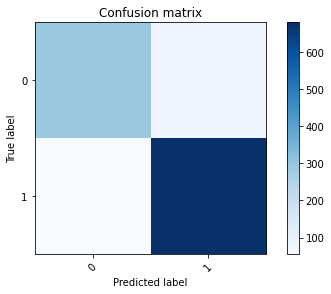

              precision    recall  f1-score   support

           0       0.84      0.78      0.81       372
           1       0.89      0.93      0.91       734

    accuracy                           0.88      1106
   macro avg       0.87      0.85      0.86      1106
weighted avg       0.88      0.88      0.88      1106

Epoch 1/1000
104/104 - 1s - loss: 0.4325 - val_loss: 0.3518 - 587ms/epoch - 6ms/step
Epoch 2/1000
104/104 - 0s - loss: 0.3520 - val_loss: 0.3302 - 204ms/epoch - 2ms/step
Epoch 3/1000
104/104 - 0s - loss: 0.3372 - val_loss: 0.3238 - 181ms/epoch - 2ms/step
Epoch 4/1000
104/104 - 0s - loss: 0.3311 - val_loss: 0.3218 - 217ms/epoch - 2ms/step
Epoch 5/1000
104/104 - 0s - loss: 0.3273 - val_loss: 0.3196 - 223ms/epoch - 2ms/step
Epoch 6/1000
104/104 - 0s - loss: 0.3248 - val_loss: 0.3161 - 211ms/epoch - 2ms/step
Epoch 7/1000
104/104 - 0s - loss: 0.3223 - val_loss: 0.3163 - 208ms/epoch - 2ms/step
Epoch 8/1000
104/104 - 0s - loss: 0.3209 - val_loss: 0.3148 - 216ms/epoch - 2m

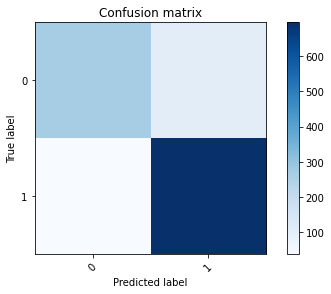

              precision    recall  f1-score   support

           0       0.88      0.72      0.79       372
           1       0.87      0.95      0.91       734

    accuracy                           0.87      1106
   macro avg       0.87      0.83      0.85      1106
weighted avg       0.87      0.87      0.87      1106

Epoch 1/1000
104/104 - 1s - loss: 0.3717 - val_loss: 0.3056 - 1s/epoch - 10ms/step
Epoch 2/1000
104/104 - 1s - loss: 0.3099 - val_loss: 0.3243 - 523ms/epoch - 5ms/step
Epoch 3/1000
104/104 - 1s - loss: 0.2826 - val_loss: 0.3158 - 620ms/epoch - 6ms/step
Epoch 3: early stopping
[1 0 0 ... 1 1 1]
------------------Result for neuron count  500  activation function:  relu  optimizer:  adam
Accuracy score: 0.8698010849909584
Precision score: 0.8683612656310745
Recall score: 0.8698010849909584
F1 score: 0.8681572690538212
              precision    recall  f1-score   support

           0       0.84      0.76      0.80       372
           1       0.88      0.93      0.90

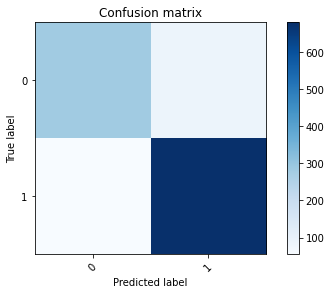

              precision    recall  f1-score   support

           0       0.84      0.76      0.80       372
           1       0.88      0.93      0.90       734

    accuracy                           0.87      1106
   macro avg       0.86      0.84      0.85      1106
weighted avg       0.87      0.87      0.87      1106

Epoch 1/1000
104/104 - 1s - loss: 0.4945 - val_loss: 0.4036 - 938ms/epoch - 9ms/step
Epoch 2/1000
104/104 - 1s - loss: 0.3800 - val_loss: 0.3514 - 518ms/epoch - 5ms/step
Epoch 3/1000
104/104 - 1s - loss: 0.3502 - val_loss: 0.3313 - 524ms/epoch - 5ms/step
Epoch 4/1000
104/104 - 1s - loss: 0.3353 - val_loss: 0.3258 - 506ms/epoch - 5ms/step
Epoch 5/1000
104/104 - 1s - loss: 0.3253 - val_loss: 0.3173 - 515ms/epoch - 5ms/step
Epoch 6/1000
104/104 - 0s - loss: 0.3187 - val_loss: 0.3131 - 495ms/epoch - 5ms/step
Epoch 7/1000
104/104 - 0s - loss: 0.3133 - val_loss: 0.3118 - 489ms/epoch - 5ms/step
Epoch 8/1000
104/104 - 1s - loss: 0.3085 - val_loss: 0.3113 - 525ms/epoch - 5m

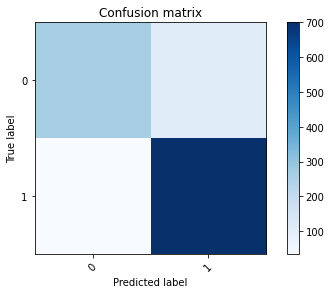

              precision    recall  f1-score   support

           0       0.89      0.70      0.78       372
           1       0.86      0.95      0.91       734

    accuracy                           0.87      1106
   macro avg       0.87      0.83      0.85      1106
weighted avg       0.87      0.87      0.87      1106

Epoch 1/1000
104/104 - 1s - loss: 0.5017 - val_loss: 0.3368 - 1s/epoch - 13ms/step
Epoch 2/1000
104/104 - 1s - loss: 0.3666 - val_loss: 0.3160 - 550ms/epoch - 5ms/step
Epoch 3/1000
104/104 - 1s - loss: 0.3503 - val_loss: 0.4485 - 622ms/epoch - 6ms/step
Epoch 4/1000
104/104 - 1s - loss: 0.3386 - val_loss: 0.3093 - 620ms/epoch - 6ms/step
Epoch 5/1000
104/104 - 1s - loss: 0.3337 - val_loss: 0.3157 - 644ms/epoch - 6ms/step
Epoch 6/1000
104/104 - 1s - loss: 0.3337 - val_loss: 0.3063 - 547ms/epoch - 5ms/step
Epoch 7/1000
104/104 - 1s - loss: 0.3268 - val_loss: 0.3219 - 548ms/epoch - 5ms/step
Epoch 8/1000
104/104 - 1s - loss: 0.3245 - val_loss: 0.3089 - 642ms/epoch - 6ms/

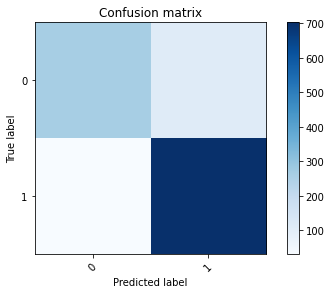

              precision    recall  f1-score   support

           0       0.89      0.70      0.79       372
           1       0.86      0.96      0.91       734

    accuracy                           0.87      1106
   macro avg       0.88      0.83      0.85      1106
weighted avg       0.87      0.87      0.87      1106

Epoch 1/1000
104/104 - 1s - loss: 0.6296 - val_loss: 0.6297 - 1s/epoch - 10ms/step
Epoch 2/1000
104/104 - 1s - loss: 0.6089 - val_loss: 0.6103 - 561ms/epoch - 5ms/step
Epoch 3/1000
104/104 - 0s - loss: 0.5901 - val_loss: 0.5915 - 483ms/epoch - 5ms/step
Epoch 4/1000
104/104 - 1s - loss: 0.5761 - val_loss: 0.5839 - 553ms/epoch - 5ms/step
Epoch 5/1000
104/104 - 1s - loss: 0.5603 - val_loss: 0.5554 - 560ms/epoch - 5ms/step
Epoch 6/1000
104/104 - 1s - loss: 0.5418 - val_loss: 0.5311 - 515ms/epoch - 5ms/step
Epoch 7/1000
104/104 - 0s - loss: 0.5230 - val_loss: 0.5468 - 470ms/epoch - 5ms/step
Epoch 8/1000
104/104 - 1s - loss: 0.5079 - val_loss: 0.4983 - 574ms/epoch - 6ms/

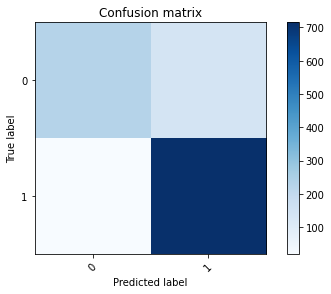

              precision    recall  f1-score   support

           0       0.92      0.62      0.74       372
           1       0.83      0.97      0.90       734

    accuracy                           0.85      1106
   macro avg       0.88      0.80      0.82      1106
weighted avg       0.86      0.85      0.85      1106

Epoch 1/1000
104/104 - 1s - loss: 0.4119 - val_loss: 0.3188 - 1s/epoch - 11ms/step
Epoch 2/1000
104/104 - 1s - loss: 0.3474 - val_loss: 0.3243 - 564ms/epoch - 5ms/step
Epoch 3/1000
104/104 - 1s - loss: 0.3317 - val_loss: 0.3554 - 566ms/epoch - 5ms/step
Epoch 3: early stopping
[1 0 0 ... 1 1 1]
------------------Result for neuron count  500  activation function:  tanh  optimizer:  adam
Accuracy score: 0.8625678119349005
Precision score: 0.8609605978628725
Recall score: 0.8625678119349005
F1 score: 0.861056737849523
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       372
           1       0.88      0.92      0.90 

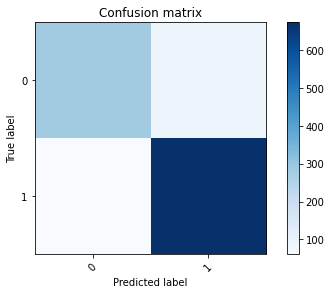

              precision    recall  f1-score   support

           0       0.82      0.76      0.79       372
           1       0.88      0.92      0.90       734

    accuracy                           0.86      1106
   macro avg       0.85      0.84      0.84      1106
weighted avg       0.86      0.86      0.86      1106

Epoch 1/1000
104/104 - 1s - loss: 0.4068 - val_loss: 0.3298 - 895ms/epoch - 9ms/step
Epoch 2/1000
104/104 - 1s - loss: 0.3331 - val_loss: 0.3132 - 517ms/epoch - 5ms/step
Epoch 3/1000
104/104 - 1s - loss: 0.3256 - val_loss: 0.3111 - 634ms/epoch - 6ms/step
Epoch 4/1000
104/104 - 1s - loss: 0.3219 - val_loss: 0.3090 - 599ms/epoch - 6ms/step
Epoch 5/1000
104/104 - 1s - loss: 0.3200 - val_loss: 0.3080 - 520ms/epoch - 5ms/step
Epoch 6/1000
104/104 - 1s - loss: 0.3193 - val_loss: 0.3052 - 560ms/epoch - 5ms/step
Epoch 7/1000
104/104 - 1s - loss: 0.3178 - val_loss: 0.3068 - 586ms/epoch - 6ms/step
Epoch 8/1000
104/104 - 0s - loss: 0.3164 - val_loss: 0.3058 - 480ms/epoch - 5m

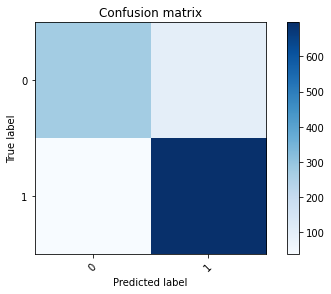

              precision    recall  f1-score   support

           0       0.88      0.73      0.80       372
           1       0.88      0.95      0.91       734

    accuracy                           0.88      1106
   macro avg       0.88      0.84      0.86      1106
weighted avg       0.88      0.88      0.87      1106

Epoch 1/1000
104/104 - 2s - loss: 0.3804 - val_loss: 0.3468 - 2s/epoch - 18ms/step
Epoch 2/1000
104/104 - 1s - loss: 0.3088 - val_loss: 0.3128 - 1s/epoch - 13ms/step
Epoch 3/1000
104/104 - 1s - loss: 0.2826 - val_loss: 0.3198 - 1s/epoch - 14ms/step
Epoch 4/1000
104/104 - 1s - loss: 0.2693 - val_loss: 0.3249 - 1s/epoch - 13ms/step
Epoch 4: early stopping
[1 0 0 ... 1 1 1]
------------------Result for neuron count  1000  activation function:  relu  optimizer:  adam
Accuracy score: 0.864376130198915
Precision score: 0.8630754612040078
Recall score: 0.864376130198915
F1 score: 0.8634143230666448
              precision    recall  f1-score   support

           0       

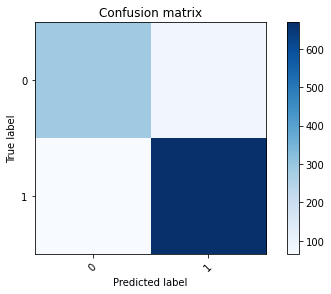

              precision    recall  f1-score   support

           0       0.82      0.77      0.79       372
           1       0.89      0.91      0.90       734

    accuracy                           0.86      1106
   macro avg       0.85      0.84      0.85      1106
weighted avg       0.86      0.86      0.86      1106

Epoch 1/1000
104/104 - 2s - loss: 0.5104 - val_loss: 0.4085 - 2s/epoch - 17ms/step
Epoch 2/1000
104/104 - 1s - loss: 0.3838 - val_loss: 0.3500 - 1s/epoch - 13ms/step
Epoch 3/1000
104/104 - 1s - loss: 0.3500 - val_loss: 0.3317 - 1s/epoch - 13ms/step
Epoch 4/1000
104/104 - 1s - loss: 0.3344 - val_loss: 0.3208 - 1s/epoch - 13ms/step
Epoch 5/1000
104/104 - 1s - loss: 0.3244 - val_loss: 0.3149 - 1s/epoch - 13ms/step
Epoch 6/1000
104/104 - 1s - loss: 0.3172 - val_loss: 0.3113 - 1s/epoch - 13ms/step
Epoch 7/1000
104/104 - 1s - loss: 0.3119 - val_loss: 0.3096 - 1s/epoch - 13ms/step
Epoch 8/1000
104/104 - 1s - loss: 0.3074 - val_loss: 0.3084 - 1s/epoch - 13ms/step
Epoch 9/1

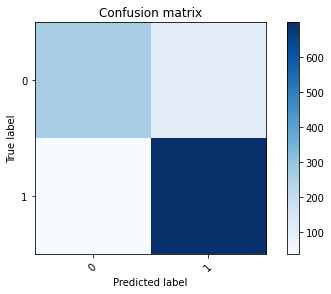

              precision    recall  f1-score   support

           0       0.88      0.72      0.79       372
           1       0.87      0.95      0.91       734

    accuracy                           0.87      1106
   macro avg       0.88      0.83      0.85      1106
weighted avg       0.87      0.87      0.87      1106

Epoch 1/1000
104/104 - 2s - loss: 0.6028 - val_loss: 0.3331 - 2s/epoch - 19ms/step
Epoch 2/1000
104/104 - 1s - loss: 0.3651 - val_loss: 0.3278 - 1s/epoch - 14ms/step
Epoch 3/1000
104/104 - 1s - loss: 0.3437 - val_loss: 0.3097 - 1s/epoch - 14ms/step
Epoch 4/1000
104/104 - 1s - loss: 0.3573 - val_loss: 0.3353 - 1s/epoch - 13ms/step
Epoch 5/1000
104/104 - 1s - loss: 0.3355 - val_loss: 0.3256 - 1s/epoch - 13ms/step
Epoch 5: early stopping
[1 0 0 ... 1 1 1]
------------------Result for neuron count  1000  activation function:  sigmoid  optimizer:  adam
Accuracy score: 0.8761301989150091
Precision score: 0.8771851900060496
Recall score: 0.8761301989150091
F1 score: 0.876

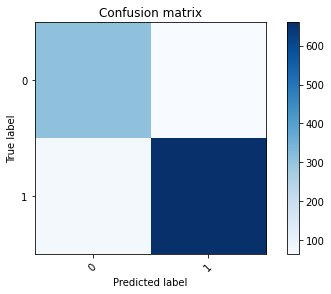

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       372
           1       0.91      0.90      0.91       734

    accuracy                           0.88      1106
   macro avg       0.86      0.86      0.86      1106
weighted avg       0.88      0.88      0.88      1106

Epoch 1/1000
104/104 - 2s - loss: 0.6392 - val_loss: 0.6182 - 2s/epoch - 16ms/step
Epoch 2/1000
104/104 - 1s - loss: 0.6176 - val_loss: 0.7408 - 1s/epoch - 12ms/step
Epoch 3/1000
104/104 - 1s - loss: 0.5965 - val_loss: 0.5815 - 1s/epoch - 12ms/step
Epoch 4/1000
104/104 - 1s - loss: 0.5848 - val_loss: 0.5656 - 1s/epoch - 12ms/step
Epoch 5/1000
104/104 - 1s - loss: 0.5647 - val_loss: 0.5791 - 1s/epoch - 12ms/step
Epoch 6/1000
104/104 - 1s - loss: 0.5471 - val_loss: 0.5235 - 1s/epoch - 12ms/step
Epoch 7/1000
104/104 - 1s - loss: 0.5242 - val_loss: 0.5992 - 1s/epoch - 12ms/step
Epoch 8/1000
104/104 - 1s - loss: 0.5206 - val_loss: 0.4897 - 1s/epoch - 12ms/step
Epoch 9/1

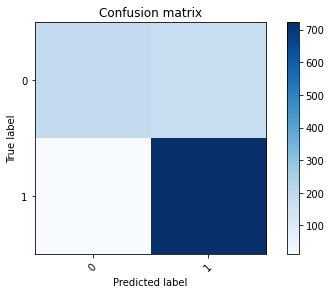

              precision    recall  f1-score   support

           0       0.94      0.52      0.67       372
           1       0.80      0.98      0.88       734

    accuracy                           0.83      1106
   macro avg       0.87      0.75      0.78      1106
weighted avg       0.85      0.83      0.81      1106

Epoch 1/1000
104/104 - 2s - loss: 0.4404 - val_loss: 0.3279 - 2s/epoch - 18ms/step
Epoch 2/1000
104/104 - 1s - loss: 0.3470 - val_loss: 0.3405 - 1s/epoch - 13ms/step
Epoch 3/1000
104/104 - 1s - loss: 0.3396 - val_loss: 0.3215 - 1s/epoch - 14ms/step
Epoch 4/1000
104/104 - 1s - loss: 0.3325 - val_loss: 0.3186 - 1s/epoch - 14ms/step
Epoch 5/1000
104/104 - 1s - loss: 0.3268 - val_loss: 0.3105 - 1s/epoch - 14ms/step
Epoch 6/1000
104/104 - 1s - loss: 0.3281 - val_loss: 0.3245 - 1s/epoch - 14ms/step
Epoch 7/1000
104/104 - 1s - loss: 0.3217 - val_loss: 0.3080 - 1s/epoch - 14ms/step
Epoch 8/1000
104/104 - 1s - loss: 0.3161 - val_loss: 0.3124 - 1s/epoch - 13ms/step
Epoch 9/1

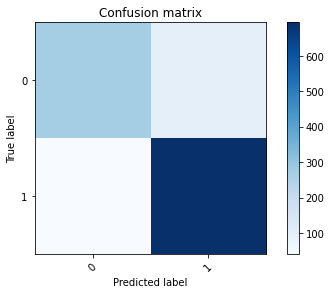

              precision    recall  f1-score   support

           0       0.87      0.73      0.80       372
           1       0.87      0.95      0.91       734

    accuracy                           0.87      1106
   macro avg       0.87      0.84      0.85      1106
weighted avg       0.87      0.87      0.87      1106

Epoch 1/1000
104/104 - 2s - loss: 0.4078 - val_loss: 0.3247 - 2s/epoch - 16ms/step
Epoch 2/1000
104/104 - 1s - loss: 0.3334 - val_loss: 0.3152 - 1s/epoch - 12ms/step
Epoch 3/1000
104/104 - 1s - loss: 0.3269 - val_loss: 0.3068 - 1s/epoch - 12ms/step
Epoch 4/1000
104/104 - 1s - loss: 0.3225 - val_loss: 0.3090 - 1s/epoch - 12ms/step
Epoch 5/1000
104/104 - 1s - loss: 0.3216 - val_loss: 0.3091 - 1s/epoch - 12ms/step
Epoch 5: early stopping
[1 0 0 ... 1 1 1]
------------------Result for neuron count  1000  activation function:  tanh  optimizer:  sgd
Accuracy score: 0.8725135623869801
Precision score: 0.8722528629095222
Recall score: 0.8725135623869801
F1 score: 0.8694861

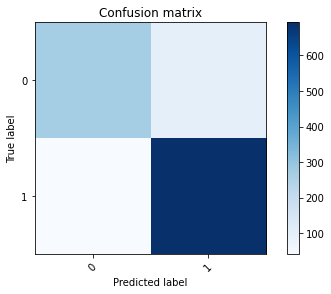

              precision    recall  f1-score   support

           0       0.87      0.73      0.79       372
           1       0.87      0.94      0.91       734

    accuracy                           0.87      1106
   macro avg       0.87      0.84      0.85      1106
weighted avg       0.87      0.87      0.87      1106



In [ ]:
# Best performance

# • Activation: relu 
# • Layers: 3
# • Neuron counts: 10
# • Optimizer: adam

neuronCountList = [100, 500, 1000]
activationFunctionList = ["relu", "sigmoid", "tanh"]
optimizerList = ["adam", "sgd"]



def FNNModelFunction(neuronCount, activationf, optimizerf):
  model = Sequential()
  model.add(Dense(neuronCount, input_dim=x.shape[1], activation=activationf))
  model.add(Dense(neuronCount,activation=activationf))
  model.add(Dense(y.shape[1],activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer=optimizerf)

  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')  
# patience: number of epochs with no improvement after which training will be stopped

# The test set is checked during training to monitor progress for early stopping but is never used for gradient descent (model training)

  model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor], verbose=2, epochs=1000)

  pred = model.predict(x_test)

  pred = np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)
  print(pred)
  y_true= np.argmax(y_test,axis=1) 

  score = metrics.accuracy_score(y_true, pred)

  print("------------------Result for neuron count ", neuronCount, " activation function: ", activationf, " optimizer: ", optimizerf  )
  print("Accuracy score: {}".format(score))
  score = metrics.precision_score(y_true, pred, average= "weighted")
  print("Precision score: {}".format(score))
  score = metrics.recall_score(y_true, pred, average= "weighted")
  print("Recall score: {}".format(score))
  score = metrics.f1_score(y_true, pred, average= "weighted")
  print("F1 score: {}".format(score))
  print(metrics.classification_report(y_true, pred))

  # Compute confusion matrix
  cm = confusion_matrix(y_true, pred)
  print(cm)
  diagnosis = encode_text_index(df_no_dup,'Target')

  print('Plotting confusion matrix')

  plt.figure()
  plot_confusion_matrix(cm, diagnosis)
  plt.show()

  print(classification_report(y_true, pred))


for neuronCount in neuronCountList:
  for activationF in activationFunctionList:
    for optimizerF in optimizerList:
      FNNModelFunction(neuronCount, activationF, optimizerF)


In [ ]:
# Predict
pred = model.predict(x_test)

pred = np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)
print(pred)
y_true= np.argmax(y_test,axis=1) 

score = metrics.accuracy_score(y_true, pred)

print("Accuracy score: {}".format(score))
score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))
score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))
print(metrics.classification_report(y_true, pred))

[1 0 0 ... 1 1 1]
Accuracy score: 0.8761301989150091
Precision score: 0.8754748921053275
Recall score: 0.8761301989150091
F1 score: 0.8736516661783951
              precision    recall  f1-score   support

           0       0.87      0.75      0.80       372
           1       0.88      0.94      0.91       734

    accuracy                           0.88      1106
   macro avg       0.87      0.84      0.86      1106
weighted avg       0.88      0.88      0.87      1106



[[278  94]
 [ 43 691]]
Plotting confusion matrix


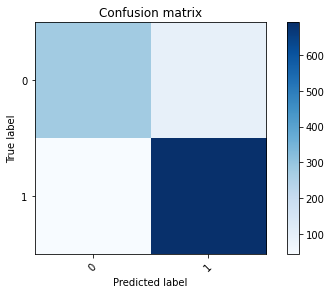

              precision    recall  f1-score   support

           0       0.87      0.75      0.80       372
           1       0.88      0.94      0.91       734

    accuracy                           0.88      1106
   macro avg       0.87      0.84      0.86      1106
weighted avg       0.88      0.88      0.87      1106



In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)
diagnosis = encode_text_index(df_no_dup,'Target')

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, diagnosis)
plt.show()

print(classification_report(y_true, pred))

### **K Nearest Neighbor**

___________________
K VALUE:  1
[1 0 1 ... 1 1 1]
Accuracy score: 0.786618444846293
Precision score: 0.7833501604174662
Recall score: 0.786618444846293
F1 score: 0.7844430660127195
              precision    recall  f1-score   support

           0       0.70      0.65      0.67       372
           1       0.83      0.86      0.84       734

    accuracy                           0.79      1106
   macro avg       0.76      0.75      0.76      1106
weighted avg       0.78      0.79      0.78      1106

[[240 132]
 [104 630]]
Plotting confusion matrix


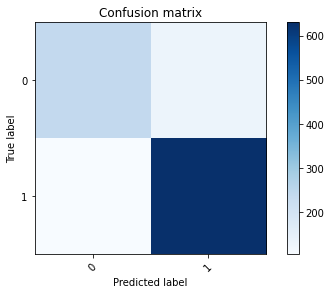

              precision    recall  f1-score   support

           0       0.70      0.65      0.67       372
           1       0.83      0.86      0.84       734

    accuracy                           0.79      1106
   macro avg       0.76      0.75      0.76      1106
weighted avg       0.78      0.79      0.78      1106

___________________
K VALUE:  2
[1 0 0 ... 1 1 1]
Accuracy score: 0.7649186256781193
Precision score: 0.7838502892051618
Recall score: 0.7649186256781193
F1 score: 0.7697831414845324
              precision    recall  f1-score   support

           0       0.62      0.77      0.69       372
           1       0.87      0.76      0.81       734

    accuracy                           0.76      1106
   macro avg       0.74      0.77      0.75      1106
weighted avg       0.78      0.76      0.77      1106

[[285  87]
 [173 561]]
Plotting confusion matrix


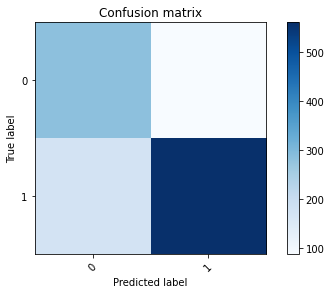

              precision    recall  f1-score   support

           0       0.62      0.77      0.69       372
           1       0.87      0.76      0.81       734

    accuracy                           0.76      1106
   macro avg       0.74      0.77      0.75      1106
weighted avg       0.78      0.76      0.77      1106

___________________
K VALUE:  3
[1 0 1 ... 1 1 1]
Accuracy score: 0.8164556962025317
Precision score: 0.8143400948291882
Recall score: 0.8164556962025317
F1 score: 0.8094377385765297
              precision    recall  f1-score   support

           0       0.80      0.61      0.69       372
           1       0.82      0.92      0.87       734

    accuracy                           0.82      1106
   macro avg       0.81      0.77      0.78      1106
weighted avg       0.81      0.82      0.81      1106

[[227 145]
 [ 58 676]]
Plotting confusion matrix


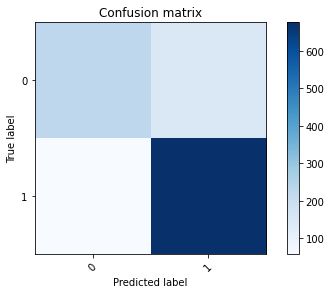

              precision    recall  f1-score   support

           0       0.80      0.61      0.69       372
           1       0.82      0.92      0.87       734

    accuracy                           0.82      1106
   macro avg       0.81      0.77      0.78      1106
weighted avg       0.81      0.82      0.81      1106

___________________
K VALUE:  4
[1 0 1 ... 1 1 1]
Accuracy score: 0.8182640144665461
Precision score: 0.815896876128534
Recall score: 0.8182640144665461
F1 score: 0.8166260547900623
              precision    recall  f1-score   support

           0       0.75      0.70      0.72       372
           1       0.85      0.88      0.87       734

    accuracy                           0.82      1106
   macro avg       0.80      0.79      0.79      1106
weighted avg       0.82      0.82      0.82      1106

[[259 113]
 [ 88 646]]
Plotting confusion matrix


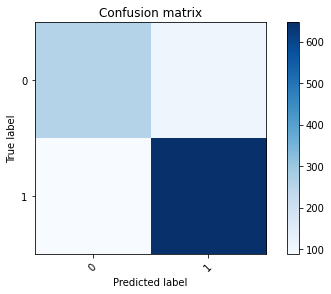

              precision    recall  f1-score   support

           0       0.75      0.70      0.72       372
           1       0.85      0.88      0.87       734

    accuracy                           0.82      1106
   macro avg       0.80      0.79      0.79      1106
weighted avg       0.82      0.82      0.82      1106

___________________
K VALUE:  5
[1 0 1 ... 1 1 1]
Accuracy score: 0.833634719710669
Precision score: 0.8382136873736836
Recall score: 0.833634719710669
F1 score: 0.8243614314323015
              precision    recall  f1-score   support

           0       0.87      0.60      0.71       372
           1       0.82      0.95      0.88       734

    accuracy                           0.83      1106
   macro avg       0.85      0.78      0.80      1106
weighted avg       0.84      0.83      0.82      1106

[[222 150]
 [ 34 700]]
Plotting confusion matrix


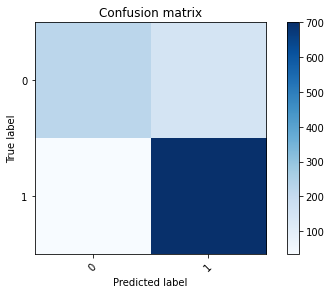

              precision    recall  f1-score   support

           0       0.87      0.60      0.71       372
           1       0.82      0.95      0.88       734

    accuracy                           0.83      1106
   macro avg       0.85      0.78      0.80      1106
weighted avg       0.84      0.83      0.82      1106

___________________
K VALUE:  6
[1 0 1 ... 1 1 1]
Accuracy score: 0.8372513562386981
Precision score: 0.836221531076732
Recall score: 0.8372513562386981
F1 score: 0.8318265911237566
              precision    recall  f1-score   support

           0       0.83      0.65      0.73       372
           1       0.84      0.93      0.88       734

    accuracy                           0.84      1106
   macro avg       0.83      0.79      0.81      1106
weighted avg       0.84      0.84      0.83      1106

[[243 129]
 [ 51 683]]
Plotting confusion matrix


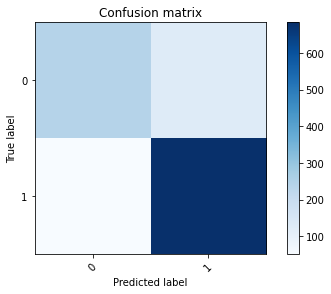

              precision    recall  f1-score   support

           0       0.83      0.65      0.73       372
           1       0.84      0.93      0.88       734

    accuracy                           0.84      1106
   macro avg       0.83      0.79      0.81      1106
weighted avg       0.84      0.84      0.83      1106

___________________
K VALUE:  7
[1 0 1 ... 1 1 1]
Accuracy score: 0.8309222423146474
Precision score: 0.8395292056014311
Recall score: 0.8309222423146474
F1 score: 0.819543067292883
              precision    recall  f1-score   support

           0       0.89      0.57      0.69       372
           1       0.82      0.96      0.88       734

    accuracy                           0.83      1106
   macro avg       0.85      0.77      0.79      1106
weighted avg       0.84      0.83      0.82      1106

[[212 160]
 [ 27 707]]
Plotting confusion matrix


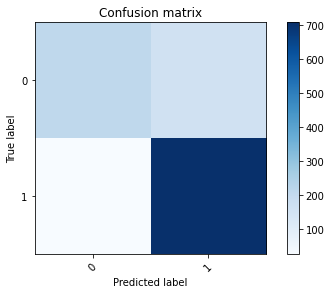

              precision    recall  f1-score   support

           0       0.89      0.57      0.69       372
           1       0.82      0.96      0.88       734

    accuracy                           0.83      1106
   macro avg       0.85      0.77      0.79      1106
weighted avg       0.84      0.83      0.82      1106

___________________
K VALUE:  8
[1 0 1 ... 1 1 1]
Accuracy score: 0.8381555153707052
Precision score: 0.840324662193466
Recall score: 0.8381555153707052
F1 score: 0.830653700329952
              precision    recall  f1-score   support

           0       0.86      0.62      0.72       372
           1       0.83      0.95      0.89       734

    accuracy                           0.84      1106
   macro avg       0.84      0.79      0.80      1106
weighted avg       0.84      0.84      0.83      1106

[[232 140]
 [ 39 695]]
Plotting confusion matrix


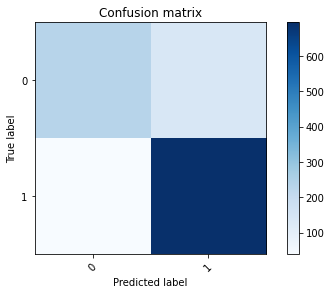

              precision    recall  f1-score   support

           0       0.86      0.62      0.72       372
           1       0.83      0.95      0.89       734

    accuracy                           0.84      1106
   macro avg       0.84      0.79      0.80      1106
weighted avg       0.84      0.84      0.83      1106

___________________
K VALUE:  9
[1 0 1 ... 1 1 1]
Accuracy score: 0.8300180831826401
Precision score: 0.838746074174872
Recall score: 0.8300180831826401
F1 score: 0.8184570446044808
              precision    recall  f1-score   support

           0       0.89      0.57      0.69       372
           1       0.81      0.96      0.88       734

    accuracy                           0.83      1106
   macro avg       0.85      0.77      0.79      1106
weighted avg       0.84      0.83      0.82      1106

[[211 161]
 [ 27 707]]
Plotting confusion matrix


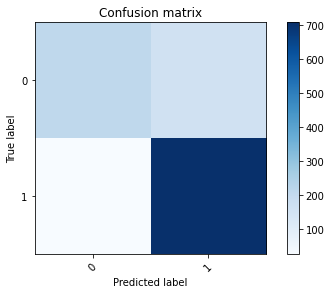

              precision    recall  f1-score   support

           0       0.89      0.57      0.69       372
           1       0.81      0.96      0.88       734

    accuracy                           0.83      1106
   macro avg       0.85      0.77      0.79      1106
weighted avg       0.84      0.83      0.82      1106

___________________
K VALUE:  10
[1 0 1 ... 1 1 1]
Accuracy score: 0.8363471971066908
Precision score: 0.8386448711761676
Recall score: 0.8363471971066908
F1 score: 0.8285636167936902
              precision    recall  f1-score   support

           0       0.86      0.62      0.72       372
           1       0.83      0.95      0.88       734

    accuracy                           0.84      1106
   macro avg       0.84      0.78      0.80      1106
weighted avg       0.84      0.84      0.83      1106

[[230 142]
 [ 39 695]]
Plotting confusion matrix


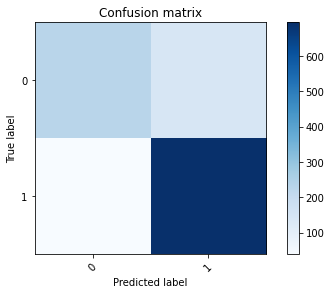

              precision    recall  f1-score   support

           0       0.86      0.62      0.72       372
           1       0.83      0.95      0.88       734

    accuracy                           0.84      1106
   macro avg       0.84      0.78      0.80      1106
weighted avg       0.84      0.84      0.83      1106

Highest Accuracy was 0.840324662193466 and it belonged to a K value of 8
Lowest Accuracy was 0.7833501604174662 and it belonged to a K value of 1


In [28]:
highest = 0
lowest = 0
best_k = 0
worst_k = 0
for i in range(1,11):
  print("___________________")
  print("K VALUE: ",i)
  # train
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(x_train, y_train)
  # predict
  pred = knn.predict(x_test)
  pred = np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)
  print(pred)
  y_true= np.argmax(y_test,axis=1) 

  score = metrics.accuracy_score(y_true, pred)

  #analyze
  print("Accuracy score: {}".format(score))
  score = metrics.precision_score(y_true, pred, average= "weighted")
  if(i==1):
    worst_k=i
    lowest=score
  if(score > highest):
    best_k=i
    highest=score
  elif(score < lowest):
    worst_k=i
    lowest=score
  print("Precision score: {}".format(score))
  score = metrics.recall_score(y_true, pred, average= "weighted")
  print("Recall score: {}".format(score))
  score = metrics.f1_score(y_true, pred, average= "weighted")
  print("F1 score: {}".format(score))
  print(metrics.classification_report(y_true, pred))

  # Compute confusion matrix
  cm = confusion_matrix(y_true, pred)
  print(cm)
  diagnosis = encode_text_index(df_no_dup,'Target')

  print('Plotting confusion matrix')

  plt.figure()
  plot_confusion_matrix(cm, diagnosis)
  plt.show()

  print(classification_report(y_true, pred))
print("Highest Accuracy was {} and it belonged to a K value of {}".format(highest, best_k))
print("Lowest Accuracy was {} and it belonged to a K value of {}".format(lowest, worst_k))